In [11]:
import os
import pandas as pd
import pathlib

curr_path = os.path.abspath('..')
folder_path = os.path.join(curr_path, 'Datasets/newsela_article_corpus_2016-01-29/')
data_path = os.path.join(folder_path, 'articles_metadata.csv')
stopwords_path = os.path.join(curr_path, 'DataExploration','newsela_stopwords.txt')
newsela = pd.read_csv(data_path)

with open(stopwords_path, 'r') as f:
    stopwords = f.read().split()

In [6]:
# Or, Loading dataset with metrics

data_path = os.path.join(folder_path, 'articles_metadata_with_scores.csv')
newsela = pd.read_csv(data_path)

# Newsela Dataset (English) Readability Baselines

Flesch-Kincaid Grade Level: Scores text at a U.S grade level.  Uses word counts, sentence counts and syllable counts.
When the number is great than 10, is the number of years required to understand the text.  Expectation: Harder the text, larger the number.  No upper bound, lowerbound -3.4 per Wikipedia.  

Flesch Reading Ease: Scale between 1 to 100 on readability (translates directly to predefined schol levels).  Higher the number, easier the text to read.  The lower the number, the more difficult.  Expectation:Harder the text, lower the number.  Upper Bound: 121.22, No theoretical lower bound.

Automated Readability Index (ARI): Uses. characters per word, word counts, sentence counts, lower bound 1 (?), no upper bound

## Calculating Heuristic Scores

In [365]:
import numpy as np
from textstat import flesch_reading_ease, flesch_kincaid_grade, automated_readability_index
import re

def get_text(filename, dp):
    fp = os.path.join(dp, 'articles', filename)
    with open(fp, 'r') as file:
        text = file.read()
    return text

# Keep only english
newsela_en = newsela[newsela['language'] == 'en']
newsela_en['f_grade'] = newsela_en['filename'].apply(lambda x: flesch_kincaid_grade(get_text(x, folder_path)))
newsela_en['f_ease'] = newsela_en['filename'].apply(lambda x: flesch_reading_ease(get_text(x, folder_path)))
newsela_en['ari'] = newsela_en['filename'].apply(lambda x: automated_readability_index(get_text(x, folder_path)))

## Calculating statistics and visualizations

In [366]:
metric_stats = newsela_en.groupby('grade_level')[['f_grade', 'f_ease', 'ari']].agg(['min', 'max', 'mean','std'])
metric_stats

f_grade                              f_ease                     \
                min    max       mean       std     min     max       mean   
grade_level                                                                  
2.0             0.7    6.5   3.709375  1.012944   73.98  105.15  88.763527   
3.0             1.9    9.4   5.107200  1.126270   59.50  102.00  82.668660   
4.0             3.8   15.9   7.006692  1.178939   49.42   91.61  75.563206   
5.0             4.7   18.0   9.001639  1.472030   43.94   89.28  68.749605   
6.0             6.4   20.7  11.373819  2.038500   36.70   79.50  60.882240   
7.0             7.8   29.1  13.080909  2.372828   15.01   75.84  54.558091   
8.0             9.6   33.0  16.351398  3.268026   -0.56   69.55  45.588438   
9.0             9.4   38.6  17.641733  3.662068   -9.66   67.93  40.025587   
10.0           13.6   34.1  22.085000  6.270925   -3.30   58.18  29.556500   
11.0           17.2   28.7  22.950000  8.131728   10.81   45.97  28.390000   
12.0            8.0  178.1  23.460389  9.378463 -383.56   80.75  25.647183   

                         ari                               
                   std   min    max       mean        std  
grade_level                                                
2.0           6.197887   2.5    9.3   5.932143   1.370131  
3.0           6.416989   3.5   13.5   7.630200   1.420106  
4.0           5.854366   5.8   21.0   9.849777   1.500931  
5.0           6.115495   7.1   24.6  12.255738   1.905201  
6.0           6.992923   9.0   27.9  15.196786   2.650904  
7.0           7.540660  10.4   37.9  17.266777   3.077811  
8.0           9.470882  13.1   42.6  21.423433   4.237835  
9.0          10.602580  12.1   50.8  22.901467   4.751045  
10.0         17.546259  17.1   44.0  28.705000   8.173801  
11.0         24.861874  23.3   36.9  30.100000   9.616652  
12.0         25.907686  11.6  227.9  30.351430  11.989751

Text(0.5, 0.98, 'Statistical Measures for Various Readability Assessment Metrics')

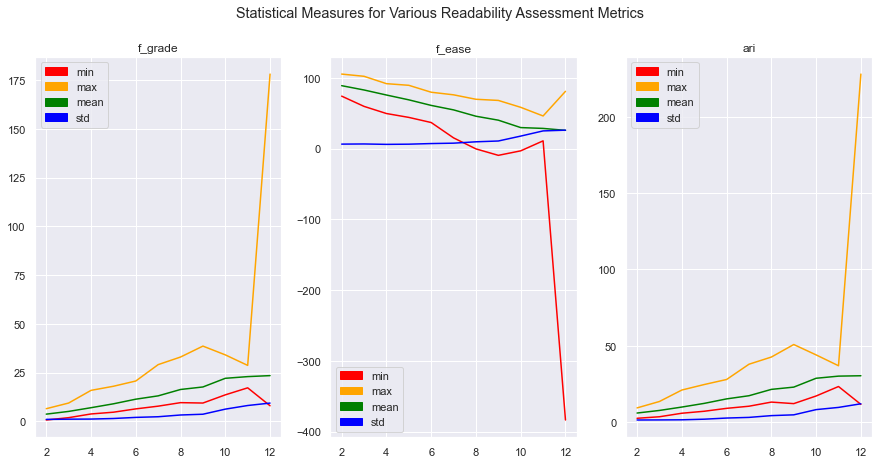

In [367]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

colors = ['red', 'orange', 'green', 'blue']
stat_types = ['min', 'max', 'mean', 'std']
score_types = ['f_grade', 'f_ease', 'ari']

fig, axs = plt.subplots(1,3, figsize=(15, 7))

x_counter = 0
y_counter = 0

for s in score_types:
    score_stats = metric_stats[s]
    score_stats.reset_index(inplace=True)
    patches = []
    
    for i in range(len(colors)):   
        axs[y_counter].plot(score_stats['grade_level'], score_stats[stat_types[i]], color=colors[i])
        patches.append(mpatches.Patch(color=colors[i], label=stat_types[i]))
    
    axs[y_counter].legend(handles=patches)
    axs[y_counter].set_title(s)
    
    if y_counter == 2:
        y_counter = 0
        x_counter = 1
    else:
        y_counter += 1

fig.suptitle('Statistical Measures for Various Readability Assessment Metrics')

## Document Distributions Over Grade Levels

In [394]:
document_dists = newsela_en.groupby(['grade_level'])['grade_level'].agg(['count'])
document_dists

,count
grade_level,
2.0,224
3.0,500
4.0,1569
5.0,1342
6.0,1058
7.0,1210
8.0,1037
9.0,750
10.0,20


Text(0.5, 1.0, 'Document Distribution Over Grade Level')

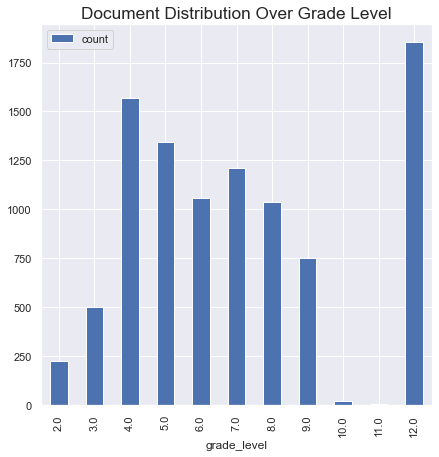

In [391]:
import matplotlib.pyplot as plt
ax = document_dists.plot.bar(y='count', use_index=True, figsize=(7,7))
ax.set_title("Document Distribution Over Grade Level", fontsize="x-large")

## N-Gram and Document Lengths

In [368]:
import numpy as np

newsela_en['avg_tokenlength'] = newsela_en['filename'].apply(lambda x: np.mean([len(w) for w in re.split('\.|\\n|\s', get_text(x, folder_path)) if w != ''])) 
newsela_en['documentlength_token'] = newsela_en['filename'].apply(lambda x: len([w for w in re.split('\.|\\n|\s', get_text(x, folder_path)) if w != '']))
newsela_en['documentlength_sentence'] = newsela_en['filename'].apply(lambda x: len([s for s in re.split('\.|\\n', get_text(x, folder_path)) if s != '']))
newsela_en['avg_sentencelength_char'] = newsela_en['filename'].apply(lambda x: np.mean([len(w) for w in re.split('\.|\\n', get_text(x, folder_path)) if w != '']))
newsela_en['avg_sentencelength_token'] = newsela_en['filename'].apply(lambda x: np.mean([len(w.split()) for w in re.split('\.|\\n', get_text(x, folder_path)) if w != '']))


In [369]:
length_stats = newsela_en.groupby('grade_level')[['documentlength_token',
                                               'documentlength_sentence',
                                               'avg_tokenlength', 
                                               'avg_sentencelength_char',
                                               'avg_sentencelength_token']].agg(['min', 'max', 'mean','std'])
length_stats

documentlength_token                                \
                             min   max        mean         std   
grade_level                                                      
2.0                          194   680  334.031250   52.618382   
3.0                          226  1457  398.148000   98.955943   
4.0                          292  1417  592.863607   88.977413   
5.0                          341  1664  684.839046  117.833966   
6.0                          397  1658  763.800567  141.888309   
7.0                          411  1774  815.682645  144.977138   
8.0                          421  1627  865.509161  148.551563   
9.0                          445  1651  856.940000  166.669345   
10.0                         580  1373  960.400000  232.187628   
11.0                         549   593  571.000000   31.112698   
12.0                         383  4503  998.126282  354.731323   

            documentlength_sentence                             \
                                min  max       mean        std   
grade_level                                                      
2.0                              28   77  47.075893   7.410364   
3.0                              29  190  48.574000  12.403234   
4.0                              31  166  61.604207  10.898278   
5.0                              26  165  62.489568  13.335049   
6.0                              28  147  62.244802  13.783486   
7.0                              28  156  61.855372  13.228466   
8.0                              29  143  59.657666  12.076073   
9.0                              26  132  55.932000  13.160483   
10.0                             30   88  60.100000  17.152259   
11.0                             28   40  34.000000   8.485281   
12.0                             16  215  58.906638  24.647634   

            avg_tokenlength                                \
                        min       max      mean       std   
grade_level                                                 
2.0                3.822878  4.897527  4.322488  0.217468   
3.0                3.837681  5.138298  4.477375  0.201950   
4.0                4.064892  5.274276  4.586133  0.179052   
5.0                4.109329  5.256289  4.667312  0.177126   
6.0                4.208000  5.367953  4.758559  0.179660   
7.0                4.328962  5.353846  4.851027  0.178015   
8.0                4.292909  5.438557  4.878766  0.184663   
9.0                4.442010  5.614256  4.978504  0.178551   
10.0               4.481343  5.536245  4.943437  0.229597   
11.0               4.854975  5.021858  4.938416  0.118004   
12.0               4.238049  5.658475  4.957848  0.207892   

            avg_sentencelength_char                                     \
                                min         max        mean        std   
grade_level                                                              
2.0                       20.606061   50.642857   37.581816   3.437531   
3.0                       29.488372   65.448980   44.744172   4.175307   
4.0                       30.414141   70.880952   53.733745   4.550136   
5.0                       42.257732   87.138889   62.267518   5.518871   
6.0                       40.798246   95.937500   70.871328   6.535669   
7.0                       48.361446  109.323529   77.424155   7.096737   
8.0                       51.431373  119.727273   85.566496   8.166591   
9.0                       56.574468  146.480769   92.258154  10.024189   
10.0                      66.935484  133.733333   97.141571  17.764135   
11.0                      86.150000  117.464286  101.807143  22.142544   
12.0                      56.138462  193.750000  104.308703  18.980918   

            avg_sentencelength_token                                  
                                 min        max       mean       std  
grade_level                                                           
2.0                         4.045455   9.714286   7.12675

Text(0.5, 0.98, 'Statistical Measures for Length Metrics')

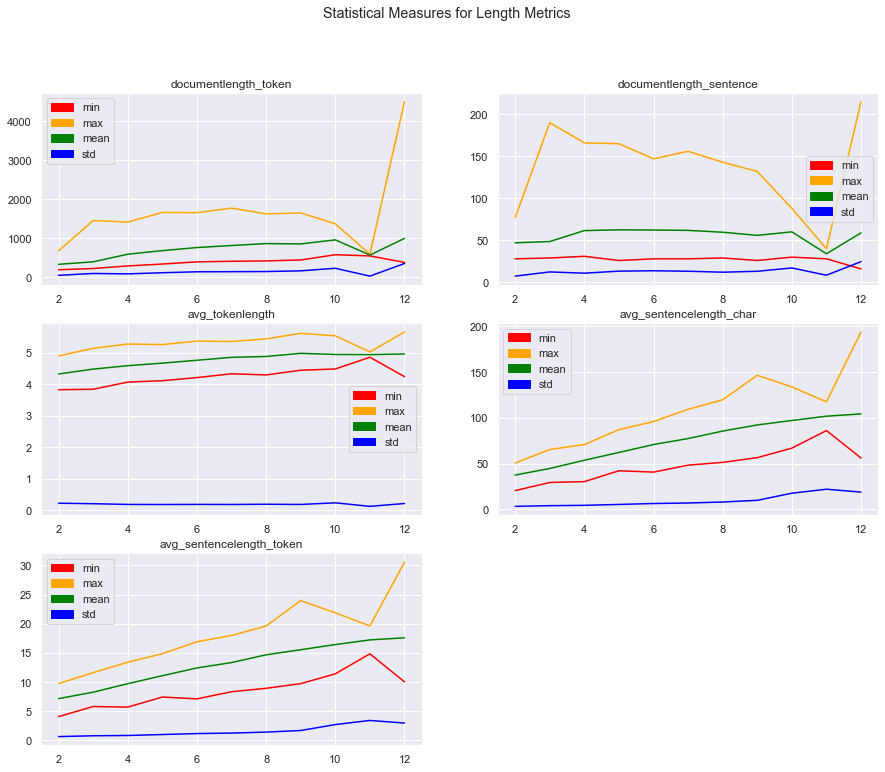

In [370]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set()

colors = ['red', 'orange', 'green', 'blue']
stat_types = ['min', 'max', 'mean', 'std']
score_types = ['documentlength_token','documentlength_sentence','avg_tokenlength', 'avg_sentencelength_char', 'avg_sentencelength_token']

fig, axs = plt.subplots(3,2, figsize=(15, 12))

x_counter = 0
y_counter = 0

for s in score_types:
    score_stats = length_stats[s]
    score_stats.reset_index(inplace=True)
    patches = []
    
    for i in range(len(colors)):   
        axs[x_counter, y_counter].plot(score_stats['grade_level'], score_stats[stat_types[i]], color=colors[i])
        patches.append(mpatches.Patch(color=colors[i], label=stat_types[i]))
    
    axs[x_counter, y_counter].legend(handles=patches)
    axs[x_counter, y_counter].set_title(s)
    
    if y_counter == 1:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1
fig.delaxes(axs[2,1])
fig.suptitle('Statistical Measures for Length Metrics')

## N-Gram Analysis

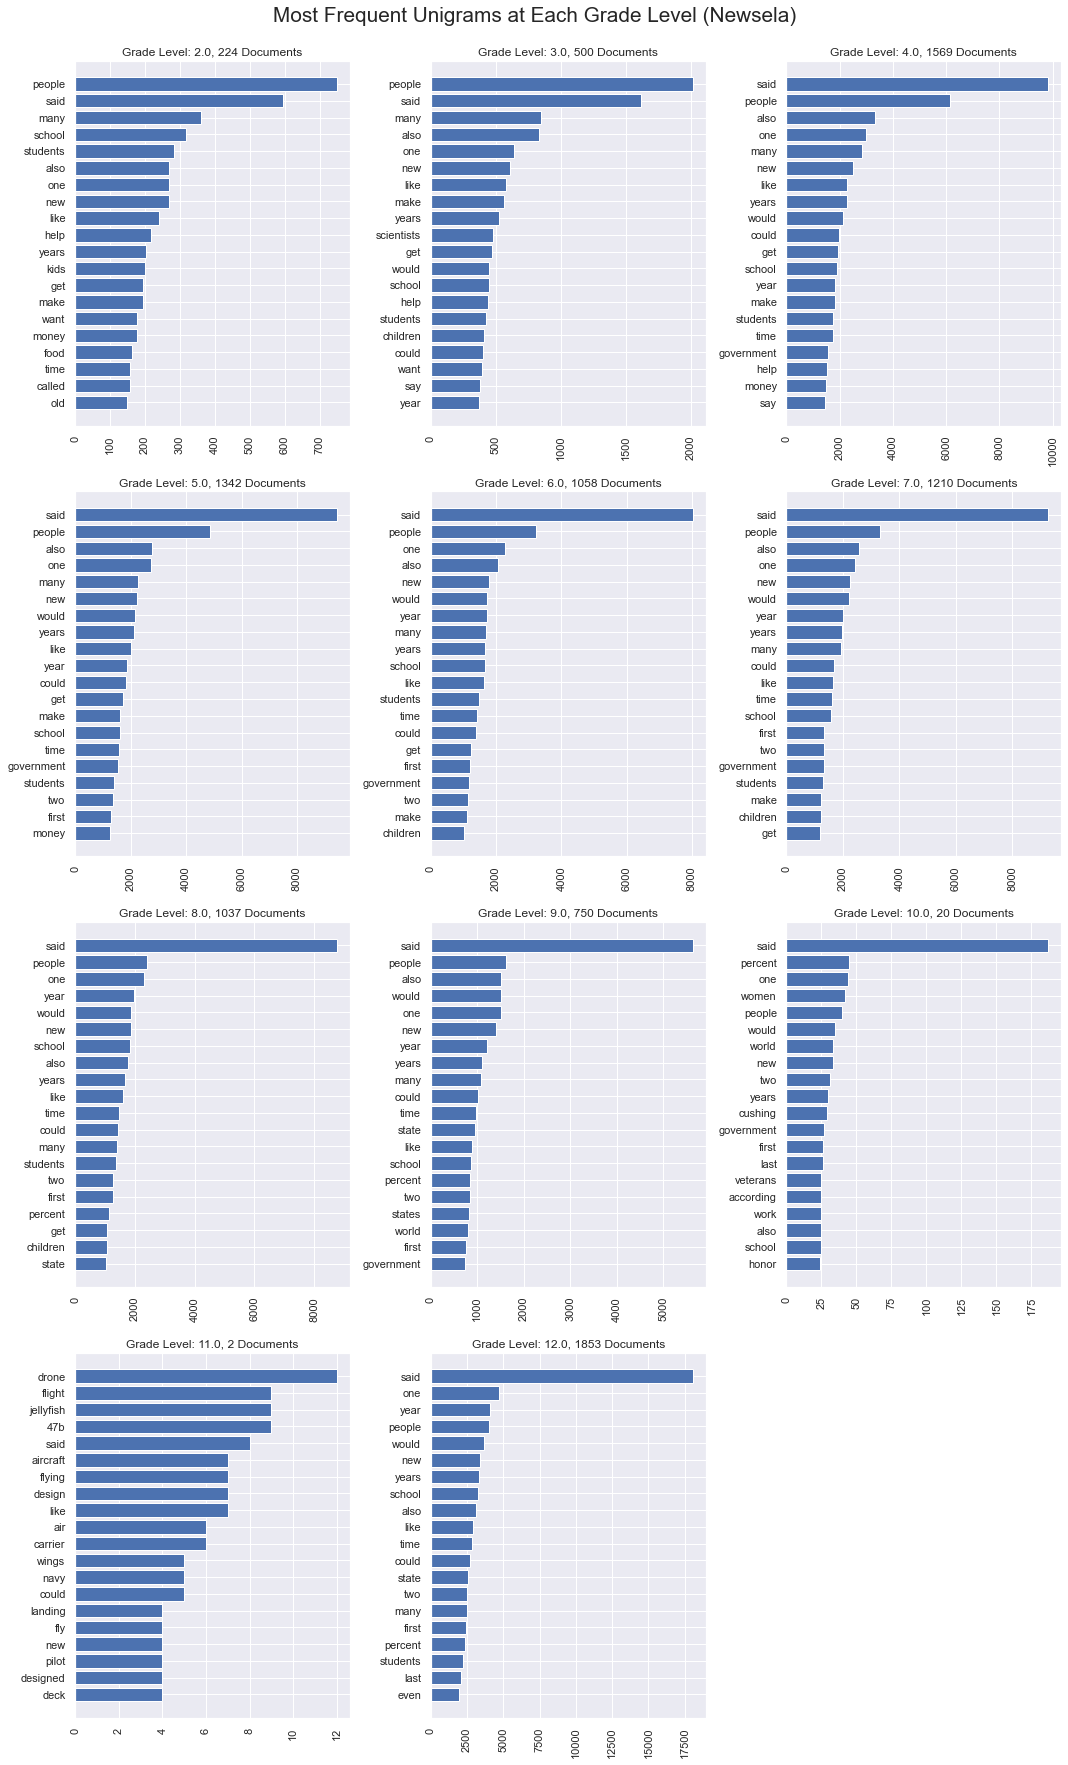

In [371]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(4,3, figsize=(15, 25))
x_counter = 0
y_counter = 0


levels = pd.unique(newsela_en['grade_level'].sort_values())

for lvl in levels:
    vectorizer = CountVectorizer(stop_words=stopwords)
    curr_level = newsela_en[newsela_en['grade_level'] == lvl]
    texts = curr_level['filename'].apply(lambda x: get_text(x, folder_path))
    counts = np.asarray(np.sum(vectorizer.fit_transform(texts), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[x_counter, y_counter].barh(keys[::-1], vals[::-1])
    axs[x_counter, y_counter].tick_params(axis='x', rotation=90)
    axs[x_counter, y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, curr_level.shape[0]))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Unigrams at Each Grade Level (Newsela)',fontsize='xx-large')
fig.delaxes(axs[3,2])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('freq_1gram_newsela.png')

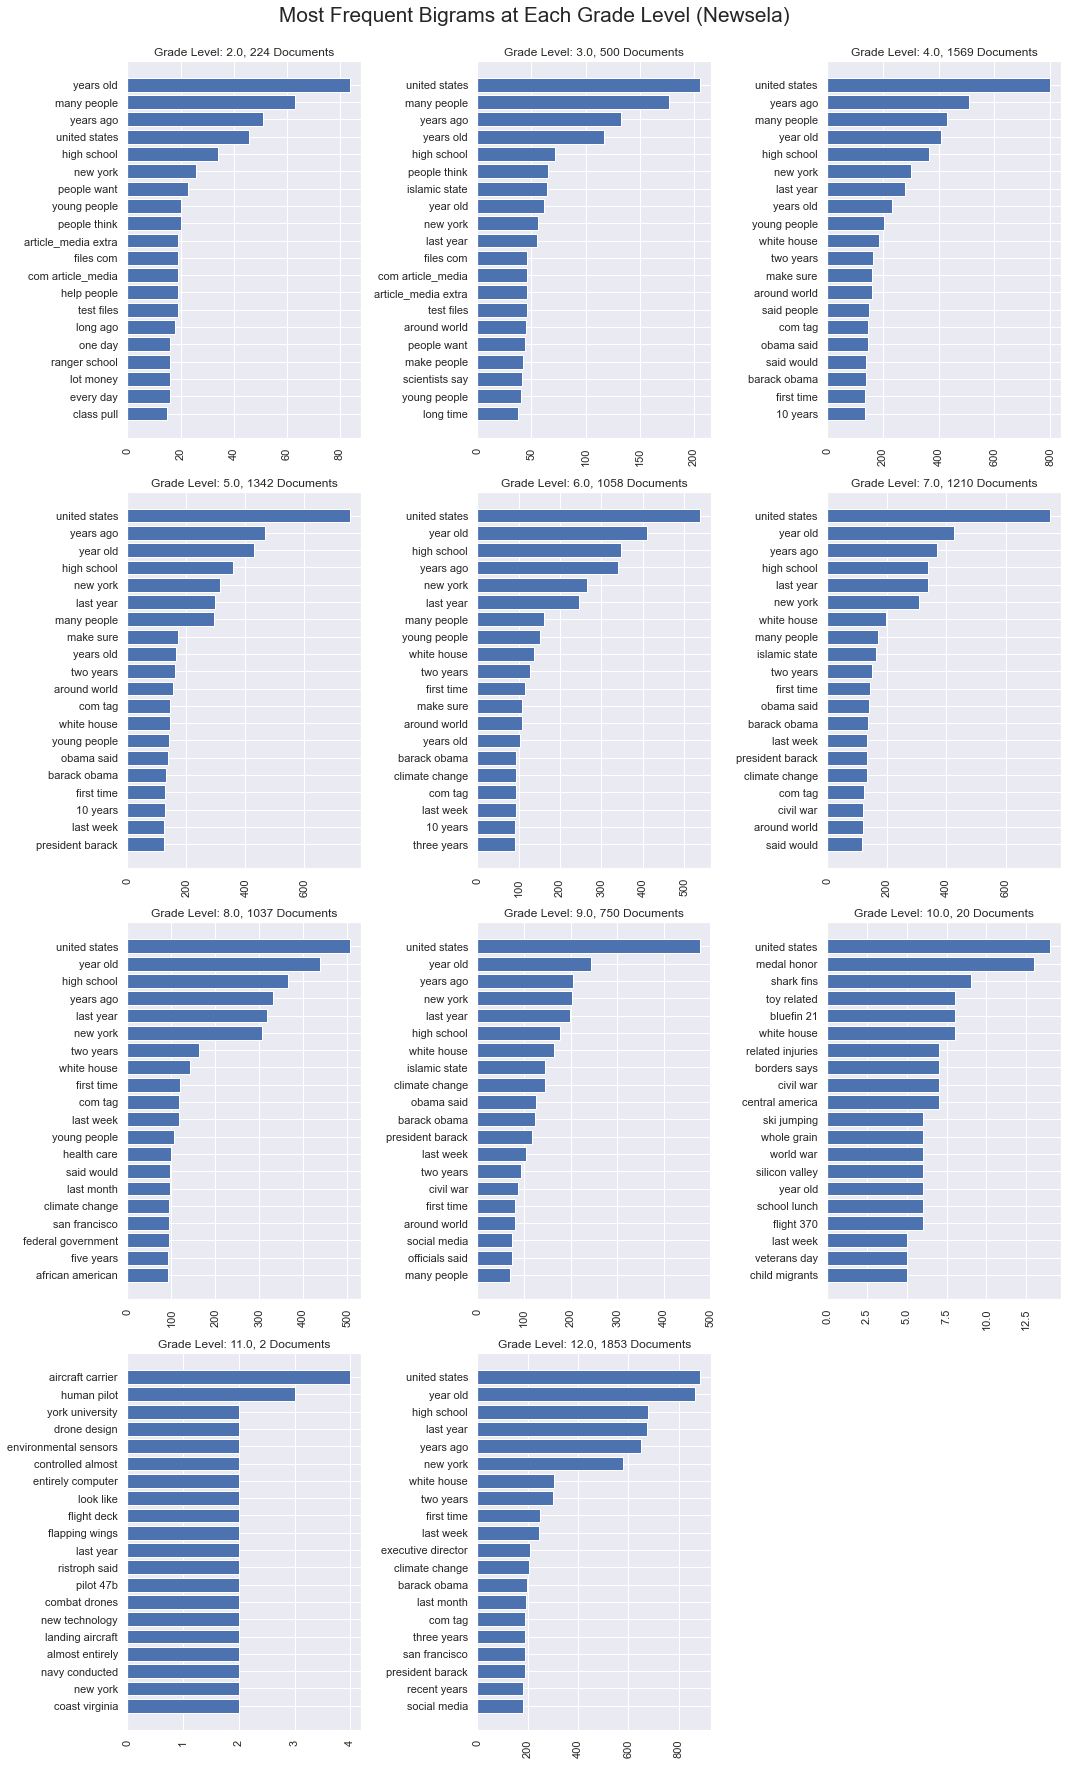

In [372]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

fig, axs = plt.subplots(4,3, figsize=(15, 25))
x_counter = 0
y_counter = 0


levels = pd.unique(newsela_en['grade_level'].sort_values())

for lvl in levels:
    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(2,2))
    curr_level = newsela_en[newsela_en['grade_level'] == lvl]
    texts = curr_level['filename'].apply(lambda x: get_text(x, folder_path))
    counts = np.asarray(np.sum(vectorizer.fit_transform(texts), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[x_counter, y_counter].barh(keys[::-1], vals[::-1])
    axs[x_counter, y_counter].tick_params(axis='x', rotation=90)
    axs[x_counter, y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, curr_level.shape[0]))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Bigrams at Each Grade Level (Newsela)',fontsize='xx-large')
fig.delaxes(axs[3,2])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('freq_2gram_newsela.png')

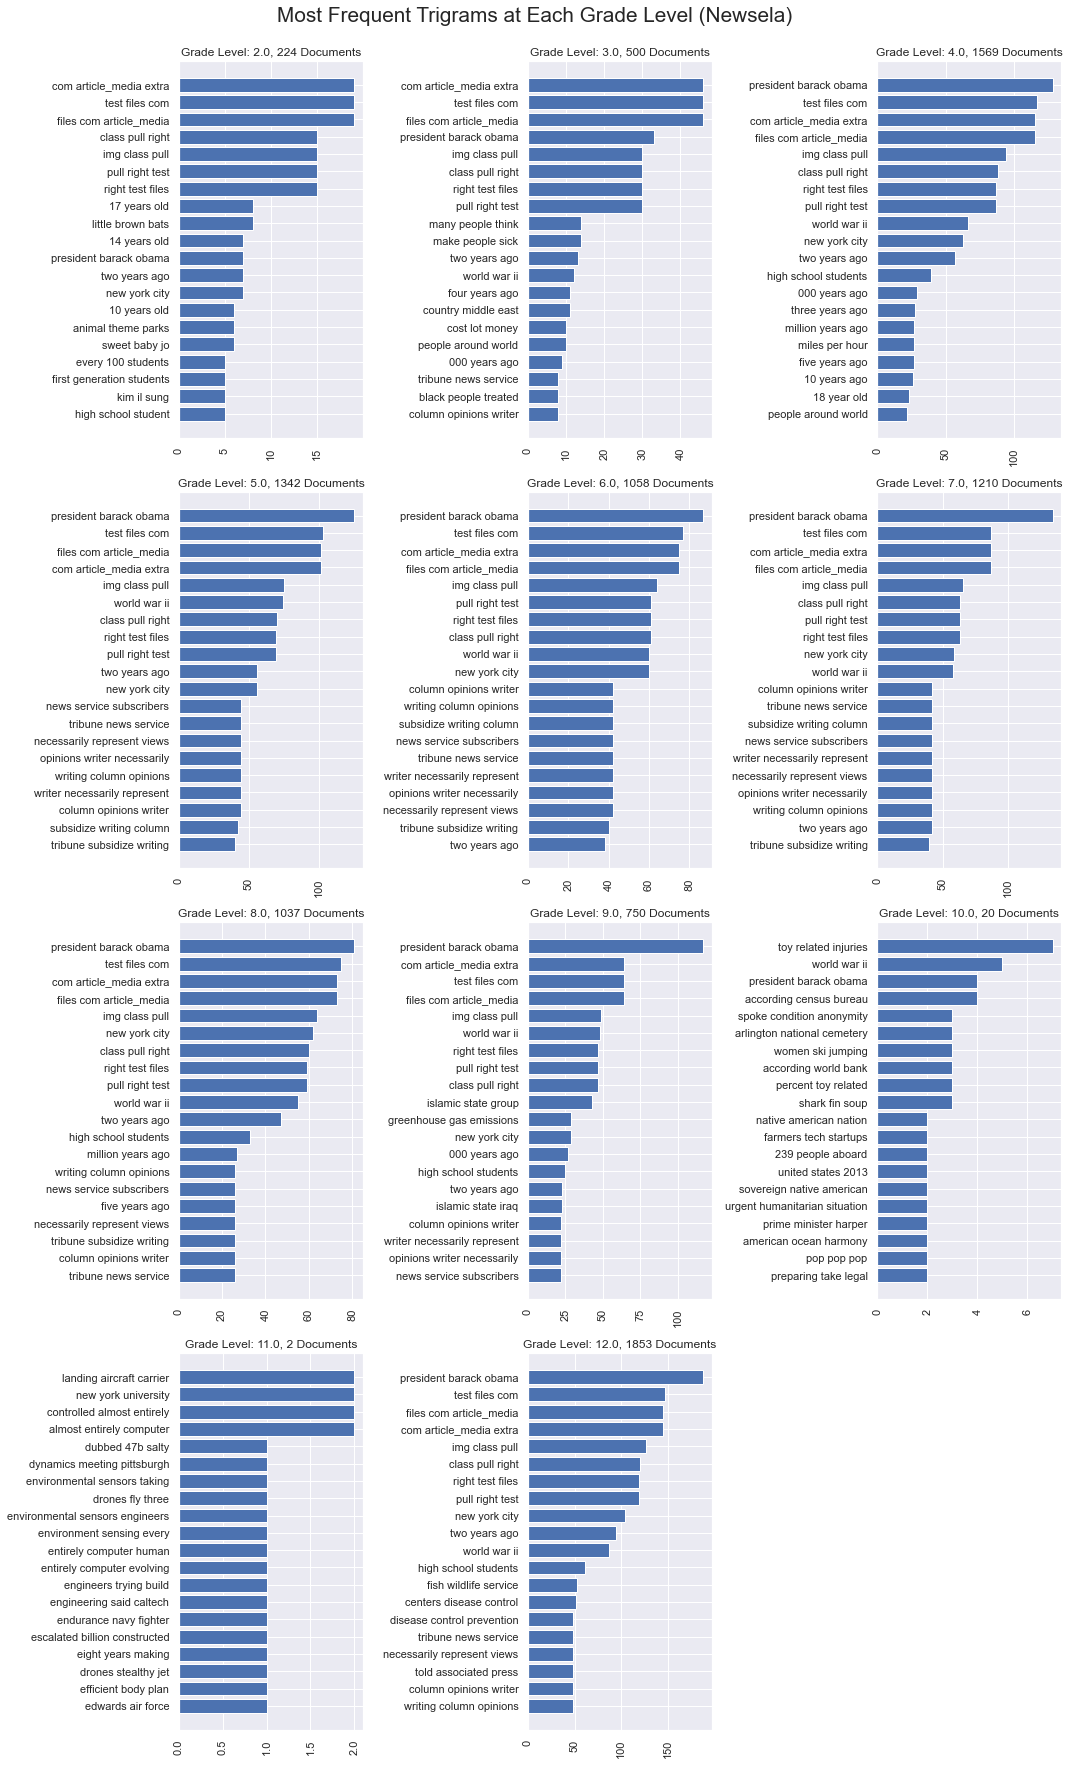

In [373]:
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter


fig, axs = plt.subplots(4,3, figsize=(15, 25))
x_counter = 0
y_counter = 0


levels = pd.unique(newsela_en['grade_level'].sort_values())

for lvl in levels:
    vectorizer = CountVectorizer(stop_words=stopwords, ngram_range=(3,3))
    curr_level = newsela_en[newsela_en['grade_level'] == lvl]
    texts = curr_level['filename'].apply(lambda x: get_text(x, folder_path))
    counts = np.asarray(np.sum(vectorizer.fit_transform(texts), axis=0)).reshape(-1)
    invert_map = {v:k for k,v in vectorizer.vocabulary_.items()}
    inds = np.argsort(counts)[::-1][:20]
    vals = np.sort(counts)[::-1][:20]
    keys = [invert_map[i] for i in inds]
        
    axs[x_counter, y_counter].barh(keys[::-1], vals[::-1])
    axs[x_counter, y_counter].tick_params(axis='x', rotation=90)
    axs[x_counter, y_counter].set_title("Grade Level: {}, {} Documents".format(lvl, curr_level.shape[0]))
    
    if y_counter == 2:
        y_counter = 0
        x_counter += 1
    else:
        y_counter += 1

    
fig.subplots_adjust(wspace=0.3)
fig.suptitle('Most Frequent Trigrams at Each Grade Level (Newsela)',fontsize='xx-large')
fig.delaxes(axs[3,2])
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.savefig('freq_3gram_newsela.png')

In [393]:
# output_path = os.path.join(folder_path, 'en_articles_metadata_with_scores.csv')
# newsela_en.to_csv(output_path, index=False)